<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="https://bokeh.org/">     
           </a>    
       </td>
       <td style="border:none">
           <h1>Uncertainty Spillover</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>Jump in [$\underline y$, $\overline y$]</h2></div>

In [115]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100, value_for_match
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams['legend.frameon'] = False

In [73]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
ȳ = 1.7
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [74]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [75]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [76]:
def simulate_jump(y_grid, solu, ME,  θ_list, y_start=1, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [77]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar, dmg_weight = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    if np.count_nonzero(dmg_weight) > 2:
        ax2.plot(πᵈt[:,-1][πᵈt[:,-1]>0], label="extreme damage")
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0, top=1)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    # plot 3
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    if np.count_nonzero(dmg_weight) > 2:
        ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
    ax3.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

In [78]:
y_lower = 1.7
y_bar = 2
y_min = 0
y_max = 4
hy = 0.02
y_grid = np.arange(y_min, y_max+hy, hy)
jump_interval = np.arange(y_lower, y_bar, hy)
pre_jump = np.arange(y_min, 1.7+hy, hy)

In [79]:
jump_idx = len(pre_jump)-1
y_grid[jump_idx]

1.7

In [463]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])

solu_dict = {}
et_dict = {}
for ȳ in jump_interval:
    pre_jump = np.arange(y_min, ȳ+hy, hy)
    numy_bar = len(pre_jump)-1
    args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
    ϕ_list, π_list = value_for_match(y_grid, numy_bar, args, report_π=True)
#     yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
    solu_dict[ȳ] = dict(ϕ_list=ϕ_list, π_list=π_list)
#     et_dict[ȳ] = etϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]

episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5048,	 ode error: 0.0003089769257152569,	 ft error: 9.98960469900112e-09
episode: 5393,	 ode error: 0.0012185046732560122,	 ft error: 9.979702989918831e-09
episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5048,	 ode error: 0.0003093762603368702,	 ft error: 9.982256502875469e-09
episode: 5391,	 ode error: 0.0012334243617965574,	 ft error: 9.977441095543327e-09
episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5047,	 ode error: 0.00030978942024931927,	 ft error: 9.996975099587265e-09
episode: 5388,	 ode error: 0.0012512570187300492,	 ft error: 9.997235631923711e-09
episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5046,	 ode error: 0.000310217314157174,	 ft error: 9.995397102594932e-09
episode: 5386,	 ode error: 0.0012728522324090578,	 ft error: 9.978394407047139e-

In [464]:
r1 = -54.16692119
r1

-54.16692119

In [465]:
solu_dict[1.7]['φ_list'].shape

(3, 201)

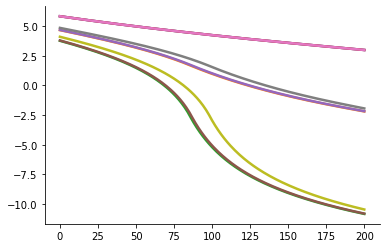

In [466]:
plt.plot(solu_dict[1.7]['φ_list'].T)
plt.plot(solu_dict[1.72]['φ_list'].T)
plt.plot(solu_dict[jump_interval[-3]]['φ_list'].T)
plt.show()

In [467]:
r0_list, time_interval_list = ([-4.382975767906238, -1.0957439419765596], [0.25, 1])
r0_list, time_interval_list

([-4.382975767906238, -1.0957439419765596], [0.25, 1])

In [468]:
y_short = np.arange(y_min, 2 + hy, hy)
short_idx = len(y_short) -1
y_grid[:short_idx+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [469]:
y_shortest = np.arange(y_min, y_lower, hy)
shortest_idx = len(y_shortest)
y_grid[shortest_idx],y_shortest

(1.7,
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68]))

In [483]:
weighted = np.zeros_like(y_short)
ϕ_list_new = np.zeros((3,len(y_short)))

for i in range(len(jump_interval)):
    ϕ_list = solu_dict[jump_interval[i]]['φ_list']
    ϕ_list_new[:, i+shortest_idx] = ϕ_list[:, i+shortest_idx]
    weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    weighted[i + shortest_idx] = weight[i+shortest_idx]
    
# for i in range(len(y_shortest)):
#     ϕ_list = solu_dict[jump_interval[0]]['φ_list']
#     weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
#     weighted[i] = weight[i]

In [484]:
len(y_short), y_short, ϕ_list[:,0+shortest_idx]

(101,
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
        1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
        1.98, 2.  ]),
 array([ 4.46255149,  2.34268377, -0.18504552]))

In [485]:
jump_interval[0], y_grid[1+shortest_idx]

(1.7, 1.72)

In [486]:
weighted.shape, y_grid[:short_idx+1].shape,  jump_interval

((101,),
 (101,),
 array([1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 ,
        1.92, 1.94, 1.96, 1.98, 2.  ]))

In [487]:
weighted[:-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## Step I:

for $m = 1,2,3$, and for $\tilde y  = 1.7, 1.72, 1.74, \dots, 1.98$ solve HJB (1) on $y \in [0,4]$:

$$
\begin{aligned}
0 = \max_{\tilde e}\min_{\omega_i^c: \sum_i^L \omega_i^c = 1} &- \delta \tilde \phi_m(y; \tilde y) + \eta \log\tilde e\\
\\
&+ \frac{1}{2} \frac{d^2 \tilde \phi_m}{dy^2}(y; \tilde y) \cdot (\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\left(\gamma_2 + \gamma_3^m\mathbb{I}\{y > \tilde y\}\right)(\tilde e)^2 |\sigma_y|^2\\
\\
    & + \sum_i \omega_i^c \left[\frac{d\tilde \phi_m}{dy}(y; \tilde y)  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \tilde y ) \mathbb{I}\{y > \tilde y\})\right] \tilde e \theta_i\\
   \\
   &+ \xi_a \sum_i \omega^c_i(\log \omega^c_i - \log \pi^c_i) \\
\end{aligned}\tag{1}
$$

And get $\{\tilde \phi_m(y;\tilde y)\}_{m=1,2,3; \tilde y = 1.7, 1.72, \dots, 1.98 }$ and let 

$$
\phi_m(\tilde y) = \tilde \phi_m(\tilde y ; \tilde y)
$$

To get $\phi_m(y)$'s value on $[1.7, 2)$ for the next step.


## step II:

Given the $\phi_m(y)$ on $[1.7, 2)$ in step I, solve HJB (2) on $y \in [0,2)$:

$$
\begin{aligned}
0 = \max_{\tilde e}\min_{\omega_i^c: \sum_i^L \omega_i^c = 1} &- \delta \phi(y) + \eta \log\tilde e\\
\\
&+ \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
\\
& + \sum_i \omega_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \omega^c_i(\log \omega^c_i - \log \hat\pi^c_i) \\
\\
 &  -   \xi_p \mathcal{I}(y)  \cfrac{ \sum_{m=1}^M \pi_m^p \exp\left( - \frac{1}{\xi_p} \phi_m\right) - \exp\left( -\frac{1}{\xi_p} \phi \right)}{\exp\left( - \frac{1}{\xi_p} \phi\right)}
\end{aligned}\tag{2}
$$

In [490]:
# solve ϕ
ξp=5
tol=1e-6
max_iter= 5000
ϵ = 0.25

solu_list = []
for i in range(len(r0_list)):
    
    intensity = r0_list[i]*(np.exp(r1/2*(y_grid[:short_idx]- y_lower)**2)-1)*(y_grid[:short_idx]>=y_lower)
    y_grid_cap = y_grid[:short_idx]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    ems = η
    ems_old = ems

    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    ϕ = np.average(solu_dict[2]['φ_list'], axis=0, weights=dmg_weight)[:short_idx]

    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy, "up")
        dϕdyy = derivative_1d(ϕ, 2, hy, "up")
        # update control
        temp = dϕdy + (η-1)/δ*dΛ 
        weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
        b = (θ_list@πᶜ)*temp
        c = η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        #     g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
        + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξw)*temp**2*ems**2*σy**2\
        + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
        - ξp*intensity*(weighted[:-1] - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[short_idx]))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    # dϕdy = derivative_1d(ϕ, 1, dy, "up")
    # dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    temp = dϕdy + (η-1)/δ*dΛ 
    h =  - temp*ems*σy/ξw
    φ_list = solu_dict[2]['φ_list'][:, shortest_idx:short_idx]
    g_list = np.array([np.exp(1/ξp*(ϕ[shortest_idx:] - ϕ_list_new[i][shortest_idx:-1])) for i in range(len(γ3_list))])
    
    πd = np.array([πdo[i]*g_list[i] for i in range(len(γ3_list))])/(πdo@g_list)
    # ι, πᵈ = get_ι(πᵈo, g_list)
    # penalty = ξp*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    solution = dict(ϕ=ϕ, ems=ems, πd=πd, πc=πᶜ)
    solu_list.append(solution)

episode: 1,	 ode error: 3.9928697883793656,	 ft error: 3.9923810671433144
episode: 2,	 ode error: 1.3442032308188883,	 ft error: 1.3400435780751105
episode: 3,	 ode error: 0.8591107971154399,	 ft error: 0.85360622276849
episode: 4,	 ode error: 0.6339444190608516,	 ft error: 0.6302562328475636
episode: 5,	 ode error: 0.5062910887570935,	 ft error: 0.4998224250600476
episode: 6,	 ode error: 0.4174856363916497,	 ft error: 0.414485204660898
episode: 7,	 ode error: 0.3679359521585131,	 ft error: 0.3633007116012248
episode: 8,	 ode error: 0.32483445312707876,	 ft error: 0.3185978733250847
episode: 9,	 ode error: 0.2872130390635928,	 ft error: 0.2798216045747459
episode: 10,	 ode error: 0.2542259190372937,	 ft error: 0.2458209539969669
episode: 11,	 ode error: 0.23370928080968983,	 ft error: 0.23125800839159538
episode: 12,	 ode error: 0.22097702589151197,	 ft error: 0.2175068548534025
episode: 13,	 ode error: 0.2089615287204844,	 ft error: 0.20451264815496817
episode: 14,	 ode error: 0.19762

episode: 209,	 ode error: 0.02561459746701863,	 ft error: 0.026552362308884803
episode: 210,	 ode error: 0.025529875687594517,	 ft error: 0.02643160551992274
episode: 211,	 ode error: 0.025440722279884986,	 ft error: 0.02630529544609317
episode: 212,	 ode error: 0.025347035039371878,	 ft error: 0.026173311773106
episode: 213,	 ode error: 0.025248711076005837,	 ft error: 0.026035535159024903
episode: 214,	 ode error: 0.02514564709858747,	 ft error: 0.025891847748438224
episode: 215,	 ode error: 0.025037739727872734,	 ft error: 0.025787984901156413
episode: 216,	 ode error: 0.02492488583957789,	 ft error: 0.025712079034104107
episode: 217,	 ode error: 0.024806982938349726,	 ft error: 0.025631965265901613
episode: 218,	 ode error: 0.024683929563624075,	 ft error: 0.02554753887886374
episode: 219,	 ode error: 0.024555625728128392,	 ft error: 0.0254586936484138
episode: 220,	 ode error: 0.02442859210992006,	 ft error: 0.025365322054390127
episode: 221,	 ode error: 0.024359779392145335,	 ft 

episode: 315,	 ode error: 0.017198613214052895,	 ft error: 0.017721762962700893
episode: 316,	 ode error: 0.017147312323893264,	 ft error: 0.017656063255714116
episode: 317,	 ode error: 0.017093710656990356,	 ft error: 0.01758764343995267
episode: 318,	 ode error: 0.017037756092813244,	 ft error: 0.017516446013972953
episode: 319,	 ode error: 0.0169793962571283,	 ft error: 0.017442413809346746
episode: 320,	 ode error: 0.01691857864047487,	 ft error: 0.017386469186014608
episode: 321,	 ode error: 0.016855250726996923,	 ft error: 0.017336070539490933
episode: 322,	 ode error: 0.016789360133947613,	 ft error: 0.017283384389756407
episode: 323,	 ode error: 0.016720854762144202,	 ft error: 0.017228357650850512
episode: 324,	 ode error: 0.016658568275494827,	 ft error: 0.017170936872199505
episode: 325,	 ode error: 0.016611618879414293,	 ft error: 0.01711106835014853
episode: 326,	 ode error: 0.01656254651030971,	 ft error: 0.017048698249851668
episode: 327,	 ode error: 0.016511302637652513

episode: 421,	 ode error: 0.012096399596544315,	 ft error: 0.012423248242843243
episode: 422,	 ode error: 0.012062926702518191,	 ft error: 0.012383509202969378
episode: 423,	 ode error: 0.012028440979310814,	 ft error: 0.012342302737339494
episode: 424,	 ode error: 0.011992633168786626,	 ft error: 0.012299600414310774
episode: 425,	 ode error: 0.011955476481759916,	 ft error: 0.012255373946533865
episode: 426,	 ode error: 0.011916944110005136,	 ft error: 0.012217863726503353
episode: 427,	 ode error: 0.011877009281481853,	 ft error: 0.012183095829525925
episode: 428,	 ode error: 0.011835645319401525,	 ft error: 0.012146993648997295
episode: 429,	 ode error: 0.01179480437493622,	 ft error: 0.012109530045277594
episode: 430,	 ode error: 0.0117622078662745,	 ft error: 0.012070677857007439
episode: 431,	 ode error: 0.011728357951306737,	 ft error: 0.012030409956862442
episode: 432,	 ode error: 0.011693229116080707,	 ft error: 0.011988699311165973
episode: 433,	 ode error: 0.011656795798219

episode: 527,	 ode error: 0.008735267483645968,	 ft error: 0.008936446395233943
episode: 528,	 ode error: 0.00871006299317055,	 ft error: 0.008907699639758349
episode: 529,	 ode error: 0.008684027035077355,	 ft error: 0.008879772576685596
episode: 530,	 ode error: 0.008657145193148037,	 ft error: 0.008855145246982943
episode: 531,	 ode error: 0.008629403129196841,	 ft error: 0.008829692125157607
episode: 532,	 ode error: 0.008603701529193875,	 ft error: 0.008803398627440728
episode: 533,	 ode error: 0.008579880554201363,	 ft error: 0.008776250225890792
episode: 534,	 ode error: 0.008555265989067987,	 ft error: 0.008748232476627038
episode: 535,	 ode error: 0.008529843864999678,	 ft error: 0.008720493493513004
episode: 536,	 ode error: 0.008503600262130886,	 ft error: 0.008696396997388334
episode: 537,	 ode error: 0.008476521336002026,	 ft error: 0.008671497616976609
episode: 538,	 ode error: 0.008451125968926415,	 ft error: 0.008645781275175679
episode: 539,	 ode error: 0.0084277842327

episode: 630,	 ode error: 0.006459746407116829,	 ft error: 0.006588258174728523
episode: 631,	 ode error: 0.006441899053960788,	 ft error: 0.006568512517196368
episode: 632,	 ode error: 0.0064235229918984185,	 ft error: 0.006548545436071862
episode: 633,	 ode error: 0.006404610191369051,	 ft error: 0.006530633496808491
episode: 634,	 ode error: 0.006385152689322007,	 ft error: 0.006512188797497487
episode: 635,	 ode error: 0.0063678666989202964,	 ft error: 0.0064932032593727484
episode: 636,	 ode error: 0.006350186341508517,	 ft error: 0.0064736688719015945
episode: 637,	 ode error: 0.006331986209496335,	 ft error: 0.006454483440673897
episode: 638,	 ode error: 0.0063132584960832044,	 ft error: 0.006436720893105985
episode: 639,	 ode error: 0.006294498783751046,	 ft error: 0.0064184343181690195
episode: 640,	 ode error: 0.006277457933528283,	 ft error: 0.006399615864207675
episode: 641,	 ode error: 0.006263914116900138,	 ft error: 0.00638025775059603
episode: 642,	 ode error: 0.0062639

episode: 736,	 ode error: 0.006267245043415193,	 ft error: 0.004833332848701133
episode: 737,	 ode error: 0.006267259561152944,	 ft error: 0.004814270050758296
episode: 738,	 ode error: 0.006267273704321199,	 ft error: 0.004794779200715027
episode: 739,	 ode error: 0.0062672874798116,	 ft error: 0.004774857058340132
episode: 740,	 ode error: 0.006267300894695078,	 ft error: 0.004754500581981347
episode: 741,	 ode error: 0.006267313956200657,	 ft error: 0.004733706940182714
episode: 742,	 ode error: 0.0062673266716922055,	 ft error: 0.004712473523131422
episode: 743,	 ode error: 0.0062673390486441966,	 ft error: 0.004690797954360448
episode: 744,	 ode error: 0.006267351094614914,	 ft error: 0.00466867810235172
episode: 745,	 ode error: 0.006267362817217004,	 ft error: 0.004646112092153487
episode: 746,	 ode error: 0.006267374224087317,	 ft error: 0.00462309831694796
episode: 747,	 ode error: 0.006267385322854271,	 ft error: 0.004599635449523021
episode: 748,	 ode error: 0.00626739612110

episode: 841,	 ode error: 0.006266327089954192,	 ft error: 0.0013531911911108807
episode: 842,	 ode error: 0.006266275212459142,	 ft error: 0.001324445193397139
episode: 843,	 ode error: 0.006266222530502092,	 ft error: 0.0012961087080292089
episode: 844,	 ode error: 0.006266169074341046,	 ft error: 0.0012681834093299926
episode: 845,	 ode error: 0.006266114875027533,	 ft error: 0.0012406706353402797
episode: 846,	 ode error: 0.006266059964334301,	 ft error: 0.0012135713960290673
episode: 847,	 ode error: 0.006266004374685101,	 ft error: 0.00118688638180231
episode: 848,	 ode error: 0.006265948139083176,	 ft error: 0.0011606159721715414
episode: 849,	 ode error: 0.006265891291040347,	 ft error: 0.0011347602447955296
episode: 850,	 ode error: 0.006265833864507023,	 ft error: 0.0011093189845787776
episode: 851,	 ode error: 0.0062657758938018705,	 ft error: 0.0010842916930116075
episode: 852,	 ode error: 0.006265717413543842,	 ft error: 0.0010596775976310369
episode: 853,	 ode error: 0.00

episode: 946,	 ode error: 0.006261376335755759,	 ft error: 7.367267627955698e-05
episode: 947,	 ode error: 0.0062613560033774815,	 ft error: 7.125684475539629e-05
episode: 948,	 ode error: 0.006261336132768365,	 ft error: 6.891168704825645e-05
episode: 949,	 ode error: 0.006261316716209709,	 ft error: 6.663532165518404e-05
episode: 950,	 ode error: 0.006261297745994404,	 ft error: 6.442591086397442e-05
episode: 951,	 ode error: 0.006261279214434038,	 ft error: 6.228165992894219e-05
episode: 952,	 ode error: 0.006261261113864016,	 ft error: 6.020081640656372e-05
episode: 953,	 ode error: 0.006261243436649674,	 ft error: 5.8181669309931294e-05
episode: 954,	 ode error: 0.006261226175191297,	 ft error: 5.622254844439567e-05
episode: 955,	 ode error: 0.006261209321929084,	 ft error: 5.4321823625969046e-05
episode: 956,	 ode error: 0.006261192869348016,	 ft error: 5.2477903942360626e-05
episode: 957,	 ode error: 0.006261176809982248,	 ft error: 5.068923703532846e-05
episode: 958,	 ode error

episode: 1051,	 ode error: 0.006260632266791223,	 ft error: 2.446487068041847e-06
episode: 1052,	 ode error: 0.006260631235553427,	 ft error: 2.4393903608199707e-06
episode: 1053,	 ode error: 0.006260630238104265,	 ft error: 2.4326928222961897e-06
episode: 1054,	 ode error: 0.0062606292734496,	 ft error: 2.4258279918143444e-06
episode: 1055,	 ode error: 0.006260628340622711,	 ft error: 2.418797285130836e-06
episode: 1056,	 ode error: 0.006260627438683459,	 ft error: 2.411602133989277e-06
episode: 1057,	 ode error: 0.006260626566717498,	 ft error: 2.404243966580566e-06
episode: 1058,	 ode error: 0.006260625723835889,	 ft error: 2.3967242430700253e-06
episode: 1059,	 ode error: 0.006260624909174877,	 ft error: 2.3898307244252237e-06
episode: 1060,	 ode error: 0.006260624121893734,	 ft error: 2.383238777881047e-06
episode: 1061,	 ode error: 0.006260623361176339,	 ft error: 2.376483301702592e-06
episode: 1062,	 ode error: 0.006260622626228465,	 ft error: 2.3695657169753304e-06
episode: 106

episode: 1155,	 ode error: 0.0062606054974288505,	 ft error: 1.804108791247927e-06
episode: 1156,	 ode error: 0.006260605521314973,	 ft error: 1.798810306041787e-06
episode: 1157,	 ode error: 0.00626060554623124,	 ft error: 1.793391712467951e-06
episode: 1158,	 ode error: 0.0062606055721359,	 ft error: 1.787899455152342e-06
episode: 1159,	 ode error: 0.006260605598989156,	 ft error: 1.7830109122485283e-06
episode: 1160,	 ode error: 0.006260605626751459,	 ft error: 1.7780008079171239e-06
episode: 1161,	 ode error: 0.006260605655385311,	 ft error: 1.7728704548858332e-06
episode: 1162,	 ode error: 0.006260605684854072,	 ft error: 1.7676211871986425e-06
episode: 1163,	 ode error: 0.006260605715122023,	 ft error: 1.7622543264650403e-06
episode: 1164,	 ode error: 0.006260605746154918,	 ft error: 1.7571041652786334e-06
episode: 1165,	 ode error: 0.0062606057779195055,	 ft error: 1.7522487532062314e-06
episode: 1166,	 ode error: 0.0062606058103837625,	 ft error: 1.7472743358837306e-06
episode:

episode: 1260,	 ode error: 0.006260609504076704,	 ft error: 1.332117355090645e-06
episode: 1261,	 ode error: 0.0062606095367990534,	 ft error: 1.3284317237349796e-06
episode: 1262,	 ode error: 0.006260609569254727,	 ft error: 1.3246575765180069e-06
episode: 1263,	 ode error: 0.0062606096014421984,	 ft error: 1.3207959970173988e-06
episode: 1264,	 ode error: 0.006260609633360285,	 ft error: 1.3168480545999728e-06
episode: 1265,	 ode error: 0.006260609665007688,	 ft error: 1.313250493240048e-06
episode: 1266,	 ode error: 0.006260609696383451,	 ft error: 1.3095729567424996e-06
episode: 1267,	 ode error: 0.0062606097274862695,	 ft error: 1.3058086238970645e-06
episode: 1268,	 ode error: 0.006260609758315171,	 ft error: 1.3019585498597053e-06
episode: 1269,	 ode error: 0.006260609788869491,	 ft error: 1.2982315755749596e-06
episode: 1270,	 ode error: 0.006260609819148208,	 ft error: 1.2946446350525775e-06
episode: 1271,	 ode error: 0.006260609849150146,	 ft error: 1.2909715572106961e-06
epi

episode: 4,	 ode error: 0.4849626702789553,	 ft error: 0.48297029258693414
episode: 5,	 ode error: 0.4075649361457962,	 ft error: 0.40435753272365194
episode: 6,	 ode error: 0.35263434125132154,	 ft error: 0.34988204694330305
episode: 7,	 ode error: 0.31168457466187327,	 ft error: 0.3084979714028231
episode: 8,	 ode error: 0.27962323993137594,	 ft error: 0.27565340283633954
episode: 9,	 ode error: 0.251010169062194,	 ft error: 0.24834027501039646
episode: 10,	 ode error: 0.23185950028127333,	 ft error: 0.22863271398309948
episode: 11,	 ode error: 0.21428038853901,	 ft error: 0.21044405478039874
episode: 12,	 ode error: 0.19804923097914662,	 ft error: 0.19362648575586672
episode: 13,	 ode error: 0.1848302206148981,	 ft error: 0.18203874178462343
episode: 14,	 ode error: 0.17536133728712017,	 ft error: 0.17205715690009526
episode: 15,	 ode error: 0.1663559711876479,	 ft error: 0.16257112981254185
episode: 16,	 ode error: 0.15778945753958223,	 ft error: 0.15354391127119804
episode: 17,	 o

episode: 212,	 ode error: 0.023835586115583004,	 ft error: 0.024759824839182265
episode: 213,	 ode error: 0.023757238952920742,	 ft error: 0.02452531821538173
episode: 214,	 ode error: 0.023673186102960084,	 ft error: 0.024526582977389744
episode: 215,	 ode error: 0.023586030323170984,	 ft error: 0.024282017320458316
episode: 216,	 ode error: 0.023492994491447112,	 ft error: 0.024272006948923952
episode: 217,	 ode error: 0.023396295984312844,	 ft error: 0.02415357942312024
episode: 218,	 ode error: 0.023295298994494687,	 ft error: 0.02396015205641433
episode: 219,	 ode error: 0.023188057618213822,	 ft error: 0.023999541040173433
episode: 220,	 ode error: 0.023077283784357853,	 ft error: 0.023808848500129542
episode: 221,	 ode error: 0.02296008902772889,	 ft error: 0.023839239818024716
episode: 222,	 ode error: 0.02283913043430028,	 ft error: 0.02364003892680877
episode: 223,	 ode error: 0.022755838318019094,	 ft error: 0.023661049085444752
episode: 224,	 ode error: 0.022689542319596717

episode: 316,	 ode error: 0.01614222265897145,	 ft error: 0.016565597684923716
episode: 317,	 ode error: 0.01608571288506453,	 ft error: 0.016559928330606155
episode: 318,	 ode error: 0.016027579199650706,	 ft error: 0.016452107678549766
episode: 319,	 ode error: 0.01596629832106536,	 ft error: 0.016402062021963815
episode: 320,	 ode error: 0.015902293603799106,	 ft error: 0.016409872370685363
episode: 321,	 ode error: 0.01583652184862245,	 ft error: 0.01629834119073159
episode: 322,	 ode error: 0.015786093323194625,	 ft error: 0.016241297871754767
episode: 323,	 ode error: 0.015740055390182348,	 ft error: 0.01624357635687801
episode: 324,	 ode error: 0.015692663684025034,	 ft error: 0.016123180810492244
episode: 325,	 ode error: 0.015642459937161332,	 ft error: 0.01605863644072869
episode: 326,	 ode error: 0.015589854916175684,	 ft error: 0.01605529121565752
episode: 327,	 ode error: 0.015535774004445717,	 ft error: 0.015937949019935616
episode: 328,	 ode error: 0.015478727801289546,	

episode: 519,	 ode error: 0.008395341633864108,	 ft error: 0.008588761795973454
episode: 520,	 ode error: 0.008370866304092145,	 ft error: 0.008560764469065063
episode: 521,	 ode error: 0.008345554335331538,	 ft error: 0.008534824444538458
episode: 522,	 ode error: 0.008319397391929204,	 ft error: 0.008506112302708146
episode: 523,	 ode error: 0.008292681651580557,	 ft error: 0.008486233292568812
episode: 524,	 ode error: 0.008268451294514874,	 ft error: 0.0084605716307955
episode: 525,	 ode error: 0.008245245946509418,	 ft error: 0.008434073364828265
episode: 526,	 ode error: 0.008221248751430953,	 ft error: 0.008402501371316262
episode: 527,	 ode error: 0.008196723241399612,	 ft error: 0.00838160826700296
episode: 528,	 ode error: 0.008171078978951897,	 ft error: 0.008358045138097125
episode: 529,	 ode error: 0.008144603585257433,	 ft error: 0.008327741447292425
episode: 530,	 ode error: 0.008121471010686686,	 ft error: 0.00830868339195412
episode: 531,	 ode error: 0.0080986393686851

episode: 627,	 ode error: 0.006117088293711659,	 ft error: 0.0062392138435853894
episode: 628,	 ode error: 0.0060989368454690066,	 ft error: 0.006203820847691333
episode: 629,	 ode error: 0.006080757312578573,	 ft error: 0.00618543361839663
episode: 630,	 ode error: 0.006064405546778465,	 ft error: 0.006166123548808855
episode: 631,	 ode error: 0.006047505699934369,	 ft error: 0.006167482296584481
episode: 632,	 ode error: 0.006029986289212974,	 ft error: 0.006131300089405656
episode: 633,	 ode error: 0.006012079584792898,	 ft error: 0.006113575748967648
episode: 634,	 ode error: 0.005994907973094349,	 ft error: 0.006094982525711501
episode: 635,	 ode error: 0.005978565302028553,	 ft error: 0.0060972547925448595
episode: 636,	 ode error: 0.0059616264612155495,	 ft error: 0.00606041549365699
episode: 637,	 ode error: 0.0059443062461793025,	 ft error: 0.006042785168617115
episode: 638,	 ode error: 0.005926477554417393,	 ft error: 0.006024950306841248
episode: 639,	 ode error: 0.005910364

episode: 829,	 ode error: 0.0037706682742706596,	 ft error: 0.0013142040609466221
episode: 830,	 ode error: 0.0037705738043381024,	 ft error: 0.0012862428875273224
episode: 831,	 ode error: 0.003770472941855594,	 ft error: 0.0012586805398093759
episode: 832,	 ode error: 0.0037703657599812285,	 ft error: 0.0012315186580593718
episode: 833,	 ode error: 0.0037702523339015123,	 ft error: 0.0012047585556018703
episode: 834,	 ode error: 0.0037701327407323355,	 ft error: 0.0011784012268201138
episode: 835,	 ode error: 0.003770007059422143,	 ft error: 0.0011524473554125336
episode: 836,	 ode error: 0.003769875370654256,	 ft error: 0.0011268973228837353
episode: 837,	 ode error: 0.003769737756750418,	 ft error: 0.0011017512172628585
episode: 838,	 ode error: 0.0037695943015764732,	 ft error: 0.0010770088419747026
episode: 839,	 ode error: 0.003769445090448756,	 ft error: 0.0010526697249311212
episode: 840,	 ode error: 0.0037692902100418466,	 ft error: 0.0010287331276934708
episode: 841,	 ode er

episode: 940,	 ode error: 0.0037408962412475363,	 ft error: 6.100840906242411e-05
episode: 941,	 ode error: 0.003740619568013453,	 ft error: 5.911678660552866e-05
episode: 942,	 ode error: 0.003740344986260951,	 ft error: 5.7283577593381096e-05
episode: 943,	 ode error: 0.0037400725259779596,	 ft error: 5.5507178107205846e-05
episode: 944,	 ode error: 0.0037398022160737114,	 ft error: 5.378602251582265e-05
episode: 945,	 ode error: 0.003739534084386195,	 ft error: 5.211858277576198e-05
episode: 946,	 ode error: 0.0037392681576900386,	 ft error: 5.0503367791776554e-05
episode: 947,	 ode error: 0.003739004461705976,	 ft error: 4.893892263169164e-05
episode: 948,	 ode error: 0.003738743021108021,	 ft error: 4.742382786560029e-05
episode: 949,	 ode error: 0.0037384838595336187,	 ft error: 4.59566989050586e-05
episode: 950,	 ode error: 0.003738226999593166,	 ft error: 4.4536185253463145e-05
episode: 951,	 ode error: 0.0037379724628789184,	 ft error: 4.316096985235163e-05
episode: 952,	 ode 

episode: 1040,	 ode error: 0.003724968623463349,	 ft error: 1.2347443738569552e-05
episode: 1041,	 ode error: 0.0037249156981627903,	 ft error: 1.2314753822018076e-05
episode: 1042,	 ode error: 0.0037248642265159324,	 ft error: 1.2282408736297157e-05
episode: 1043,	 ode error: 0.0037248141840807367,	 ft error: 1.2248592065944308e-05
episode: 1044,	 ode error: 0.003724765546466117,	 ft error: 1.2213325985221957e-05
episode: 1045,	 ode error: 0.003724718289344193,	 ft error: 1.2176632846916391e-05
episode: 1046,	 ode error: 0.003724672388460311,	 ft error: 1.2138535153916052e-05
episode: 1047,	 ode error: 0.0037246278196461334,	 ft error: 1.2099055558323357e-05
episode: 1048,	 ode error: 0.0037245845588280632,	 ft error: 1.2058216850796555e-05
episode: 1049,	 ode error: 0.003724542582039577,	 ft error: 1.202042714343321e-05
episode: 1050,	 ode error: 0.00372450186543085,	 ft error: 1.1988318243894014e-05
episode: 1051,	 ode error: 0.003724462385279445,	 ft error: 1.1954812279668658e-05
e

episode: 1143,	 ode error: 0.0037236560036189824,	 ft error: 8.92279636133253e-06
episode: 1144,	 ode error: 0.0037236594995865534,	 ft error: 8.89355041344686e-06
episode: 1145,	 ode error: 0.0037236630141769776,	 ft error: 8.863480452703243e-06
episode: 1146,	 ode error: 0.0037236665430799495,	 ft error: 8.83550127461774e-06
episode: 1147,	 ode error: 0.0037236700820834287,	 ft error: 8.810093371280914e-06
episode: 1148,	 ode error: 0.003723673627070684,	 ft error: 8.783841977333395e-06
episode: 1149,	 ode error: 0.003723677174019977,	 ft error: 8.756758324679481e-06
episode: 1150,	 ode error: 0.00372368071900386,	 ft error: 8.728853782002943e-06
episode: 1151,	 ode error: 0.003723684258185707,	 ft error: 8.700139872530599e-06
episode: 1152,	 ode error: 0.003723687787819469,	 ft error: 8.670628243834244e-06
episode: 1153,	 ode error: 0.0037236913042485997,	 ft error: 8.644986115413644e-06
episode: 1154,	 ode error: 0.003723694803904963,	 ft error: 8.619912728491386e-06
episode: 1155,

episode: 1247,	 ode error: 0.003723703548828672,	 ft error: 6.4870558862395455e-06
episode: 1248,	 ode error: 0.0037236999550531932,	 ft error: 6.46659351133394e-06
episode: 1249,	 ode error: 0.0037236963171789345,	 ft error: 6.4461610360666555e-06
episode: 1250,	 ode error: 0.0037236926371638362,	 ft error: 6.427935677066898e-06
episode: 1251,	 ode error: 0.003723688916980654,	 ft error: 6.40916300120864e-06
episode: 1252,	 ode error: 0.0037236851586158713,	 ft error: 6.389849723120733e-06
episode: 1253,	 ode error: 0.0037236813640685353,	 ft error: 6.370002656908014e-06
episode: 1254,	 ode error: 0.0037236775353489786,	 ft error: 6.349628723256728e-06
episode: 1255,	 ode error: 0.00372367367447856,	 ft error: 6.3310127931259785e-06
episode: 1256,	 ode error: 0.0037236697834866633,	 ft error: 6.3127861054113055e-06
episode: 1257,	 ode error: 0.0037236658644099682,	 ft error: 6.294028302988863e-06
episode: 1258,	 ode error: 0.0037236619192922357,	 ft error: 6.2747459725898125e-06
episo

episode: 1351,	 ode error: 0.003723419729654266,	 ft error: 4.765077068924484e-06
episode: 1352,	 ode error: 0.0037234200610181435,	 ft error: 4.7513719039216085e-06
episode: 1353,	 ode error: 0.0037234204630071134,	 ft error: 4.7383079735396905e-06
episode: 1354,	 ode error: 0.0037234209350764935,	 ft error: 4.724883046591799e-06
episode: 1355,	 ode error: 0.003723421476654231,	 ft error: 4.711101080800972e-06
episode: 1356,	 ode error: 0.003723422087143005,	 ft error: 4.697135819853315e-06
episode: 1357,	 ode error: 0.003723422765919304,	 ft error: 4.684390056297616e-06
episode: 1358,	 ode error: 0.003723423512335483,	 ft error: 4.6712874848253705e-06
episode: 1359,	 ode error: 0.0037234243257196695,	 ft error: 4.6578319690127046e-06
episode: 1360,	 ode error: 0.0037234252053753927,	 ft error: 4.644027418621022e-06
episode: 1361,	 ode error: 0.0037234261505840575,	 ft error: 4.631230636320538e-06
episode: 1362,	 ode error: 0.0037234271606046733,	 ft error: 4.618425492708411e-06
episo

episode: 1461,	 ode error: 0.0037236827590513416,	 ft error: 3.3011687001760492e-06
episode: 1462,	 ode error: 0.0037236852760240344,	 ft error: 3.2818734290174234e-06
episode: 1463,	 ode error: 0.0037236877661719105,	 ft error: 3.2624428492056268e-06
episode: 1464,	 ode error: 0.0037236902290643838,	 ft error: 3.2428810534668173e-06
episode: 1465,	 ode error: 0.003723692664285041,	 ft error: 3.2231920847891615e-06
episode: 1466,	 ode error: 0.0037236950714316236,	 ft error: 3.2033800252406763e-06
episode: 1467,	 ode error: 0.0037236974501156372,	 ft error: 3.183448917809528e-06
episode: 1468,	 ode error: 0.0037236997999632038,	 ft error: 3.1634028303528794e-06
episode: 1469,	 ode error: 0.003723702120614906,	 ft error: 3.143245798753469e-06
episode: 1470,	 ode error: 0.0037237044117235177,	 ft error: 3.1229818517886088e-06
episode: 1471,	 ode error: 0.00372370667295769,	 ft error: 3.1026150075774694e-06
episode: 1472,	 ode error: 0.003723708903999378,	 ft error: 3.082149291344649e-06


episode: 1566,	 ode error: 0.0037237777265289804,	 ft error: 1.1942924160734947e-06
episode: 1567,	 ode error: 0.003723777205189769,	 ft error: 1.1782936226722995e-06
episode: 1568,	 ode error: 0.003723776666756537,	 ft error: 1.1624268410059813e-06
episode: 1569,	 ode error: 0.0037237761115770235,	 ft error: 1.1466925649017412e-06
episode: 1570,	 ode error: 0.0037237755399981247,	 ft error: 1.1310911887107977e-06
episode: 1571,	 ode error: 0.0037237749523675034,	 ft error: 1.1156231600750743e-06
episode: 1572,	 ode error: 0.0037237743490321044,	 ft error: 1.1002888058442295e-06
episode: 1573,	 ode error: 0.0037237737303375817,	 ft error: 1.0850884635260627e-06
episode: 1574,	 ode error: 0.0037237730966302902,	 ft error: 1.0700224457593777e-06
episode: 1575,	 ode error: 0.0037237724482549334,	 ft error: 1.0550910154449866e-06
episode: 1576,	 ode error: 0.0037237717855550002,	 ft error: 1.040294399956565e-06
episode: 1577,	 ode error: 0.0037237711088734214,	 ft error: 1.0256327911406515

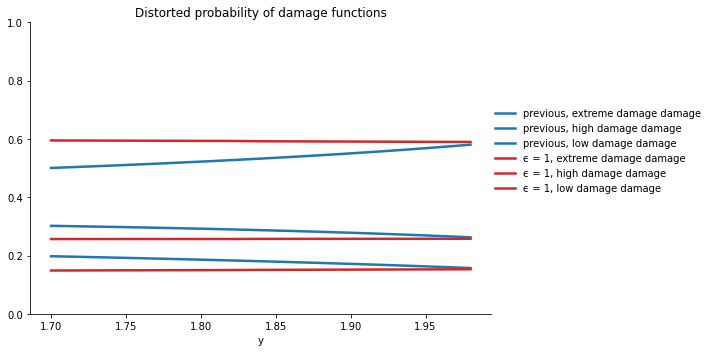

In [510]:
dmg = ['low damage', 'high damage', 'extreme damage']
fig = plt.figure(figsize=(10,5))
for i in range(len(γ3_list)):
    plt.plot(y_grid[shortest_idx:short_idx],solu_orignal['πd'][2-i, shortest_idx:-1], 
             label="previous, {} damage".format(dmg[2-i]),
            color="tab:blue")

# for i in range(len(γ3_list)):
#     plt.plot(y_grid[shortest_idx:short_idx],solu_list[0]['πd'][2-i], 
#              label="ϵ = 0.25, {} damage".format(dmg[2-i]),
#             color="red")
for i in range(len(γ3_list)):
    plt.plot(y_grid[shortest_idx:short_idx],solu_list[1]['πd'][2-i], 
             label="ϵ = 1, {} damage".format(dmg[2-i]),
            color="tab:red")

# plt.plot(y_grid[:numy_bar+1],solu_orignal['πd'].T)
# handles, _ = plt.gca().get_legend_handles_labels()
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
# plt.legend(['low damage', 'high damage', 'extreme damage'])
plt.title('Distorted probability of damage functions')
plt.legend(loc=(1,0.4))
plt.ylim(0,1)
# plt.xlim(1.7, 2)
plt.xlabel('y')
fig.tight_layout()
# plt.savefig('../figures/dmg_interval.pdf')

In [432]:
solu_list[0]['πd'] == solu_list[1]['πd'], 
solu_list[0]['πd'] == solu_orignal['πd'][:, shortest_idx:-1]

array([[False,  True, False, False,  True,  True, False, False,  True,
        False, False,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True, False],
       [ True, False, False, False, False,  True,  True,  True, False,
        False,  True,  True, False,  True,  True]])

In [433]:
y_grid[shortest_idx:short_idx]

array([1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 ,
       1.92, 1.94, 1.96, 1.98])

Text(0.5, 0, 'y')

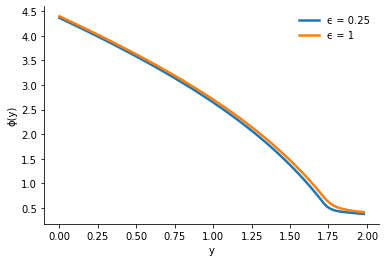

In [442]:
ep_list = [0.25, 1]
for i in range(len(r0_list)):
    plt.plot(y_grid_cap,solu_list[i]['φ'], label='ϵ = {}'.format(ep_list[i]))
# plt.ylim(0)
plt.legend()
plt.ylabel('ϕ(y)')
plt.xlabel('y')
# plt.savefig('../figures/value_interval_jump.pdf')

Text(0.5, 0, 'y')

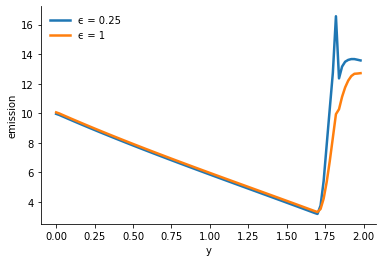

In [443]:
ep_list = [0.25, 1]
for i in range(len(r0_list)):
    plt.plot(y_grid_cap,solu_list[i]['ems'], label='ϵ = {}'.format(ep_list[i]))
# plt.ylim(0)
plt.legend()
plt.ylabel('emission')
plt.xlabel('y')
# plt.savefig('../figures/ems_interval_jump.pdf')

In [493]:
def simulate_ems(y_grid_cap, ems, πd, πc, θ_list, y_start =1 , T=100):
    yt = np.zeros(T)
    et = np.zeros(T)
    πdt = np.zeros((T, len(πd)))
    get_πd = interpolate.interp1d(y_grid_cap[shortest_idx:], πd)
    πct = np.zeros((T, len(πc)))
    get_πc = interpolate.interp1d(y_grid_cap, πc)
    y = y_start
    for t in range(T):
        
        if y <= np.max(y_grid_cap):
            e_i = np.interp(y, y_grid_cap, ems)
            if y >= y_grid_cap[shortest_idx]:
                πd_list = get_πd(y)
                πdt[t] = πd_list
            et[t] = e_i 
            πc_list = get_πc(y)
            πct[t] = πc_list
            yt[t] = y
            y = y + np.mean(θ_list)*e_i
    return yt, et, πdt, πct

In [494]:
simul = []
for i in range(len(r0_list)):
    yt,et,πdt, πct = simulate_ems(y_grid_cap, solu_list[i]['ems'], solu_list[i]['πd'], solu_list[i]['πc'], 
                                  θ_list)
    simul.append(dict(et=et, yt=yt, πdt=πdt, πct=πct))

In [495]:
solu_list[i]['πd'].shape

(3, 15)

Text(0.5, 0, 'Years')

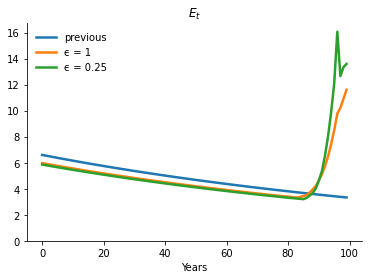

In [496]:
plt.plot(et_original, label='previous')
for i in range(len(r0_list)):
    plt.plot(simul[1-i]['et'], label='ϵ = {}'.format(ep_list[1-i]))


plt.legend()
plt.title('$E_t$')
plt.ylim(0)
plt.xlabel('Years')
# plt.savefig('../figures/ems_interval_jump.pdf')

Text(0.5, 1.0, '$SCC_t$')

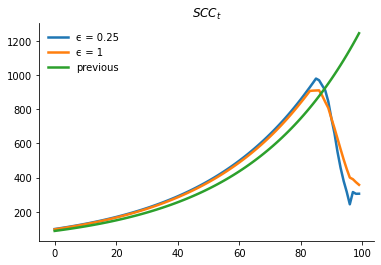

In [497]:
for i in range(len(r0_list)):
    scc, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, η/simul[i]['et'])
    plt.plot(scc, label='ϵ = {}'.format(ep_list[i]))
    
scc_original, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, η/et_original)
plt.plot(scc_original, label='previous')
plt.legend()
plt.title('$SCC_t$')
# plt.savefig('../figures/SSC_interval_jump.pdf')

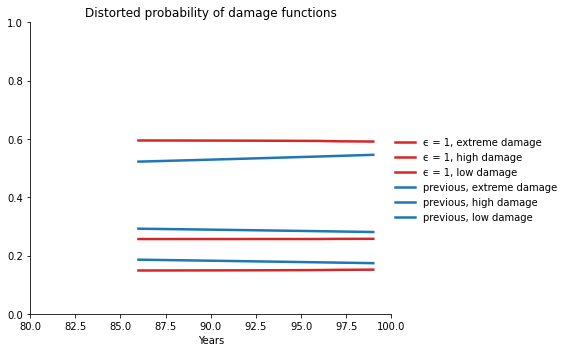

In [504]:
years = np.arange(0,100)
fig = plt.figure(figsize=(8,5))
colors=['tab:red', 'tab:blue', 'tab:green']
for i in range(len(r0_list[1:])):
    for j, dmg in enumerate(['extreme', 'high', 'low']):
        plt.plot(years[simul[i]['πdt'][:, 2-j]>0], simul[i]['πdt'][:, 2-j][simul[i]['πdt'][:, 2-j]>0], label='ϵ = {}, {} damage'.format(ep_list[1], dmg), color=colors[i])
    
# scc_original, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, η/et_original)
for j, dmg in enumerate(['extreme', 'high', 'low']):
    plt.plot(years[simul[i]['πdt'][:, 2-j]>0], πd_original[:,2-j][simul[i]['πdt'][:, 2-j]>0], 
         label='previous, {} damage'.format(dmg), 
         color=colors[1], 
#          label=['low', 'high', 'extreme']
        )
plt.legend(loc=(1,0.3))
plt.xlabel('Years')
plt.title('Distorted probability of damage functions')
plt.ylim(0,1)
plt.xlim(80,100)
fig.tight_layout()
# plt.savefig('../figures/dmg_distort.pdf', alpha=0.5, density=True)
# plt.hist(θ_list*1000, bins=bins, weights=πᶜt[50]*np.exp(-50*δ), color='tab:blue', alpha=0.5)

(0.8, 3.0)

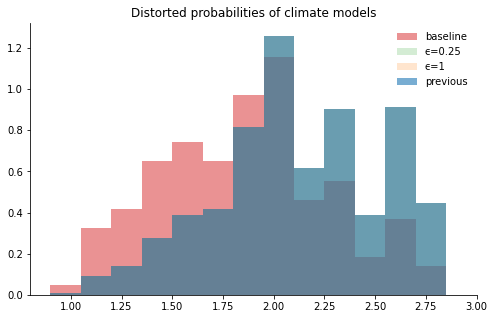

In [425]:
plt.figure(figsize=(8,5))
bins = np.linspace(0, 3, 21)
plt.hist(θ_list*1000, bins=bins, color='tab:red', alpha=0.5, density=True)

plt.hist(θ_list*1000, bins=bins, weights=simul[0]['πct'][50]*np.exp(-50*δ), color='tab:green', alpha=0.2, density=True)
plt.hist(θ_list*1000, bins=bins, weights=simul[1]['πct'][50]*np.exp(-50*δ), color='tab:orange', alpha=0.2, density=True)
plt.hist(θ_list*1000, bins=bins, weights=πᶜt[50]*np.exp(-50*δ), color='tab:blue', alpha=0.6, density=True)
plt.legend(['baseline', 'ϵ=0.25', 'ϵ=1', 'previous', ])
plt.title('Distorted probabilities of climate models')
plt.xlim(0.8,3)
# plt.savefig('../figures/climate_distortion.pdf')

 $$
     \pi_m^{p,*} =  \frac{\pi_m^p\exp(\frac{1}{\xi_p}(\phi - \phi_m))}{\sum\pi_m^p\exp(\frac{1}{\xi_p}(\phi - \phi_m)) }
 $$

In [450]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
ȳ = 2

y_min = 0
y_max = 4
hy = 0.02
y_grid = np.arange(y_min, y_max+hy, hy)
y_short = np.arange(y_min, ȳ+hy, hy)
numy_bar = len(y_short)-1

args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list, π_list = approach_one_100(y_grid, numy_bar, args, report_π=True)
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
solu_orignal = solu
et_original = et
πd_original = πᵈt

episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5038,	 ode error: 0.00031678354971511474,	 ft error: 9.998391744166687e-09
episode: 5389,	 ode error: 0.0010988225461033745,	 ft error: 9.99224999039446e-09
episode: 10000,	 ode error: 0.0007238119045097358,	 ft error: 0.00014534915273552626


ValueError: x and y must have same first dimension, but have shapes (101,) and (0,)

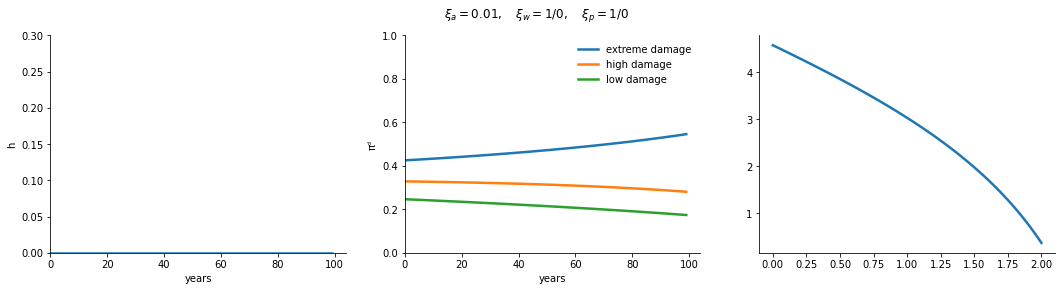

In [499]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
args_plot = (ξa, ξw, ξp, numy_bar, dmg_weight)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

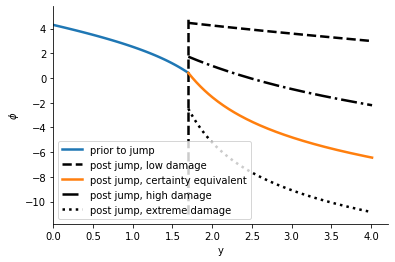

In [18]:
fig,ax3 = plt.subplots()
ϕ = solu["φ"]
ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξp*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
if np.count_nonzero(dmg_weight) > 2:
    ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
ax3.vlines(x=ȳ, ymin=-11, ymax=5, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend()

(0.0, 5.923642464027751)

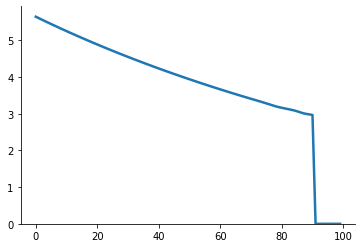

In [19]:
plt.plot(et)
plt.ylim(0)

Checkout another notebook:
[uncertainty decomposition](jump_damage_decompose_minimization_100.ipynb)

(0.8, 3.0)

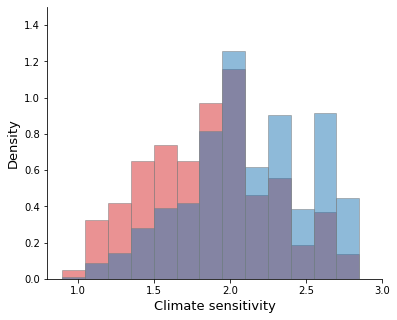

In [22]:
# histogram 10, 50, 90
from matplotlib.ticker import MaxNLocator
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-δ*50), bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)
# ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-50*δ), density=True, bins=np.linspace(1,3,14), color="tab:blue", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.hist(θ_list*1000, density=True, bins=np.linspace(1,3,14), color="tab:red", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)



# ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# plt.savefig('./paper_plots/histogram_worstcase.pdf')

(0.8, 3.0)

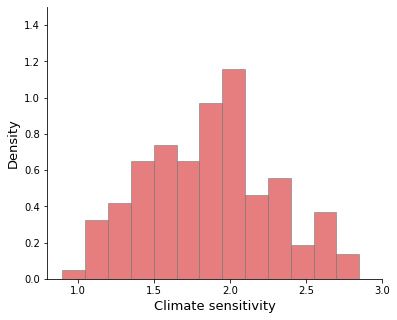

In [23]:
# histogram θ_list
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.6, density=True)
# ax2.hist(θ_list*1000, weights=πᶜt[50], bins=bins, color='tab:blue', histtype='bar', ec='darkgray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)

# plt.savefig('./paper_plots/histogram.pdf')

In [45]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = (1-η)/((α - invkap)*np.exp(Kt))
    Ct = (α - invkap)*np.exp(Kt)
    SCCt = MEt/MCt*1000
    return SCCt, Ct

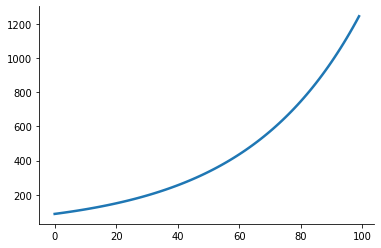

In [46]:
MEt = η/et
SCCt, Ct = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1)
plt.plot(SCCt)

In [14]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal, ems_unreveal, π_unreveal = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695666923007328,	 ft error: 9.965709146797508e-08


In [45]:
def simulate_unreveal(y_grid, ems, π, me, θ_list, y_start=1, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πt = np.zeros((periods, len(π)))
    me_t = np.zeros(periods)
    get_π = interpolate.interp1d(y_grid, π)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            π_list = get_π(y)
            if me is not None:
                me_point = np.interp(y, y_grid, me)
                me_t[t] = me_point
            et[t] = ems_point
            πt[t] = π_list
            
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    
    return yt, et, πt, me_t

In [16]:
logKt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)

In [17]:
yt_unreveal, et_unreveal, πt_unreveal, _ = simulate_unreveal(y_grid, ems_unreveal, π_unreveal, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

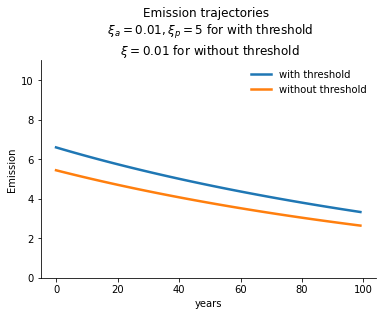

In [18]:
plt.plot(et[et>0], label="with threshold")
plt.plot(et_unreveal[:100], label="without threshold")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, '$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

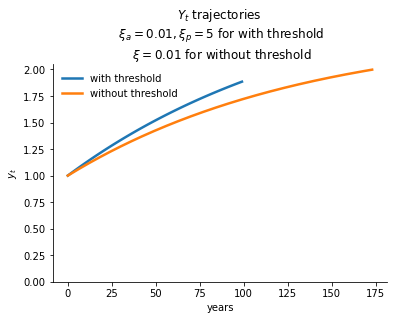

In [19]:
plt.plot(yt[yt>0], label="with threshold")
plt.plot(yt_unreveal[yt_unreveal<=2], label="without threshold")
plt.ylim(0)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("$y_t$")
plt.title("$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, 'SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

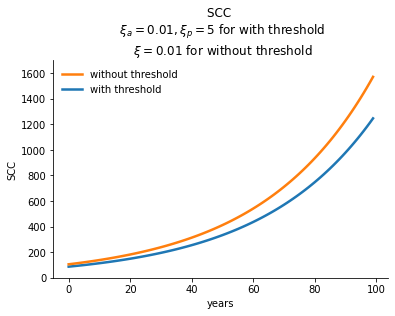

In [20]:
SCCt_unreveal = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal[:100]*1000
plt.plot(SCCt, label="with threshold")
plt.plot(SCCt_unreveal, label="without threshold")
plt.ylim(0,1700)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/scc_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [21]:
ξa = 1000*100
ξw = 1000*100
ξp = 1000*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)
yt_base, et_base, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 10000,	 ode error: 0.00011710457906673188,	 ft error: 0.00012173167466637362
episode: 5012,	 ode error: 0.000328243742822254,	 ft error: 9.970615444387931e-09
episode: 5377,	 ode error: 0.0011686487381849346,	 ft error: 9.996075078788635e-09
episode: 1227,	 ode error: 0.000521663011021703,	 ft error: 9.933103228831897e-09


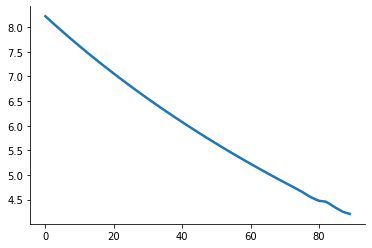

In [28]:
plt.plot(et_base[et_base>0])

In [22]:
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal_base, ems_unreveal_base, π_unreveal_base = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.000652568780844253,	 ft error: 9.846339643626578e-08


In [25]:
yt_unreveal_base, et_unreveal_base, πt_unreveal_base, _ = simulate_unreveal(y_grid, ems_unreveal_base, π_unreveal_base, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ =\\infty$ for without jump')

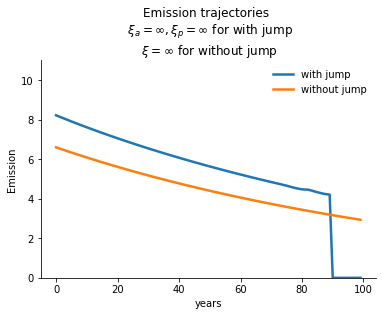

In [26]:
plt.plot(et_base, label="with jump")
plt.plot(et_unreveal_base[:100], label="without jump")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ =\infty$ for without jump")
# plt.savefig("./paper_plots/ems_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-31-e599f94ff8f7>:1: RuntimeWarning: divide by zero encountered in true_divide
  SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000


Text(0.5, 1.0, 'SCC \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ = \\infty$ for without jump')

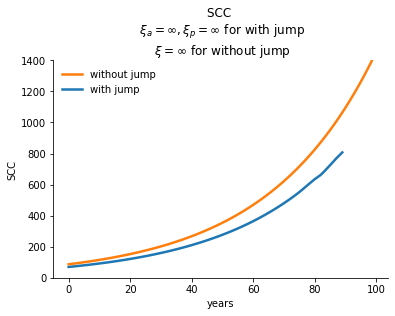

In [31]:
SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000
SCCt_unreveal_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal_base[:100]*1000
plt.plot(SCCt_base, label="with jump")
plt.plot(SCCt_unreveal_base, label="without jump")
plt.ylim(0,1400)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ = \infty$ for without jump")
# plt.savefig("./paper_plots/scc_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [33]:
n_climate = len(θ_list)
n_dmg = len(γ3_list)
πc_dict = dict()
for year in [10,50,90, -1]:
    πc_dict[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=1)

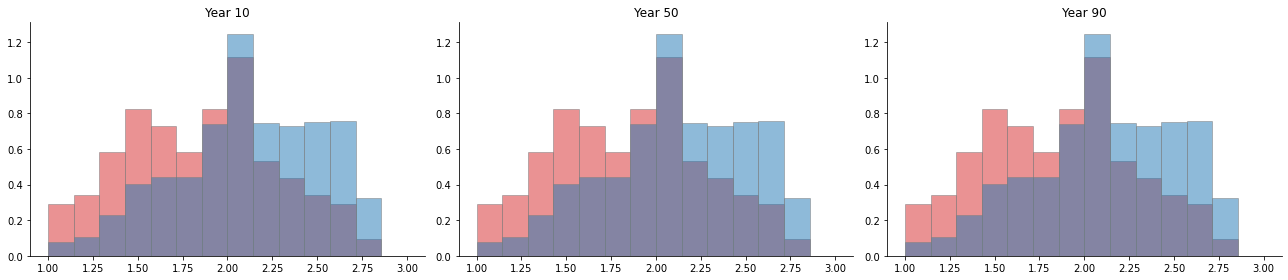

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
axes = [ax1, ax2, ax3]
bins=np.linspace(1,3,15)
ax1.set_title("Year 10")
ax1.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax1.hist(θ_list*1000, weights=πc_dict[10], bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

ax2.set_title("Year 50")
ax2.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray",color="tab:red" )
ax2.hist(θ_list*1000, weights=πc_dict[50]*np.exp(-50*δ), bins=bins, density=True, alpha=0.5, ec="gray",color="tab:blue")

ax3.set_title("Year 90")
ax3.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax3.hist(θ_list*1000, weights=πc_dict[90]*np.exp(-90*δ), bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

fig.tight_layout()
# fig.savefig("./paper_plots/hist_time.png", facecolor="w",dpi=500)

In [35]:
πd_list = np.zeros((200,3))
for year in range(200):
    πd_list[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=0)

# Decompose  for no jump version

In [36]:
def solve_smooth_unreveal_decompose(y_grid, ems_star, args, max_iter, tol, ϵ,):
    """
    solve for step one, ϕⱼ for individual damage function
    
    Parameter
    ---
    args: δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw
    """
    δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw = args
    params = list()
    for θ_i in θ_list:
        for γ3 in γ3_list:
            params.append([θ_i, γ3])
    params = np.array(params)
    θ_long = params[:,0]
    γ3_long = params[:,1]
    args_weight = (δ, η, γ1, γ2, ȳ, σy, ξa)
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
#     dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
#     ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - η*y_grid**2
    ems = η
    ems_old = ems
    πo = np.ones((len(params), n_y))/len(params)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
#         temp1 = dϕdy + (η-1)/δ*dΛ
#         temp2 = dϕdyy + (de)
        # update belief
        weight = generate_weight(params, ems_star, dϕdy, y_grid, args_weight)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
#         temp = dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)
#         ddΛ = γ2 + γ3_long@π*(y_grid>ȳ)
#         a = (dϕdyy  + (η-1)/δ*ddΛ)*σy**2
#         b = (θ_long@π)*temp + (η-1)/δ*((θ_long*γ3_long)@π)*(y_grid - ȳ)*(y_grid>ȳ)
#         c = η
#         Δ = b**2 - 4*a*c
#         Δ[Δ < 0] = 0
#         root1 = (-b - np.sqrt(Δ))/(2*a)
#         root2 = (-b + np.sqrt(Δ))/(2*a)
#         if root1.all() > 0:
#             ems_new = root1
#         else:
#             ems_new = root2
#         ems_new[ems_new < 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        dmg_drift = θ_long@π*(γ1 + γ2*y_grid)*ems_star + (θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ)*ems_star\
        + 1/2*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star**2 + 1/2*γ2*σy**2*ems_star**2
        A = - δ*np.ones(y_grid.shape)
        B = (θ_long@π)*ems_star
#         C = np.zeros(y_grid.shape)
        C = ems_star**2*σy**2/2
        D = η*np.log(ems_star) + ξa*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
            + (η-1)/δ*dmg_drift
#         - 1/(2*ξw)*temp**2*ems**2*σy**2\
#         + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
#         ems_old = ems
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    me = - θ_long@π*(dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)) - (η-1)/δ*(θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ) \
        - (η-1)/δ*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star - (η-1)/δ*γ2*σy**2*ems_star - dϕdyy*σy**2*ems_star
#     h = - temp*ems*σy/ξw
    return ϕ, ems, π, me

In [37]:
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_test, ems_test, π_test, me_unreveal = solve_smooth_unreveal_decompose(y_grid, ems_unreveal, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [38]:
ems_10 = 10*np.ones(ems_unreveal.shape)

In [39]:
ems = ems_unreveal
# ems = ems_10

In [44]:
# base
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_b, ems_b, π_b, me_b = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.0005883286089622009,	 ft error: 9.537113232482852e-08


In [45]:
# dmamage 
ξa = 1/100
args_unreveal = (δ, η, [np.average(θ_list)], σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_dmg, ems_dmg, π_dmg, me_dmg = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 5000,	 ode error: 0.0007692703380716287,	 ft error: 2.826561062840849e-05


In [46]:
# temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_temp, ems_temp, π_temp, me_temp = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006117452360071673,	 ft error: 9.824843516526016e-08


In [47]:
# carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_carb, ems_carb, π_carb, me_carb = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 687,	 ode error: 0.0005965204360334053,	 ft error: 9.99169396109778e-08


In [48]:
# total
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_total, ems_total, π_total, me_total = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [49]:
yt_b, et_b, πt_b, met_b = simulate_unreveal(y_grid, ems, π_b, me_b, θ_list, T=200)
yt_dmg, et_dmg, πt_dmg, met_dmg = simulate_unreveal(y_grid, ems, π_dmg, me_dmg, θ_list, T=200)
yt_temp, et_temp, πt_temp, met_temp = simulate_unreveal(y_grid, ems, π_temp, me_temp, θ_list, T=200)
yt_carb, et_carb, πt_carb, met_carb = simulate_unreveal(y_grid, ems, π_carb, me_carb, θ_list, T=200)
yt_total, et_total, πt_total, met_total = simulate_unreveal(y_grid, ems, π_total, me_total, θ_list, T=200)

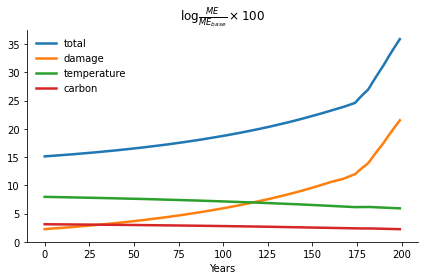

In [50]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_dmg/met_b)*100, label="damage")
plt.plot(np.log(met_temp/met_b)*100, label="temperature")
plt.plot(np.log(met_carb/met_b)*100, label="carbon")
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_1type_21.png", dpi=500, facecolor="w")

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

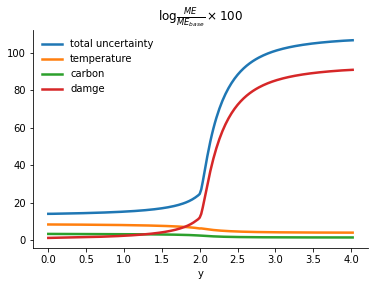

In [51]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_temp/me_b)*100, label="temperature")
plt.plot(y_grid, np.log(me_carb/me_b)*100, label="carbon")
plt.plot(y_grid, np.log(me_dmg/me_b)*100, label="damge")
plt.xlabel("y")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

In [52]:
# dmamage and temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_tempdmg, ems_tempdmg, π_tempdmg, me_tempdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008360410378625491,	 ft error: 9.874248796393204e-08


In [53]:
# dmamage and carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_carbdmg, ems_carbdmg, π_carbdmg, me_carbdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 693,	 ode error: 0.0007965239294456961,	 ft error: 9.950145329895577e-08


In [54]:
# temp and carb
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_tempcarb, ems_tempcarb, π_tempcarb, me_tempcarb = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                    args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006244045825355357,	 ft error: 9.841302439639321e-08


In [55]:
yt_carbdmg, et_carbdmg, πt_carbdmg, met_carbdmg = simulate_unreveal(y_grid, ems, π_carbdmg, me_carbdmg, θ_list, T=200)
yt_tempcarb, et_tempcarb, πt_tempcarb, met_tempcarb = simulate_unreveal(y_grid, ems, π_tempcarb, me_tempcarb, θ_list, T=200)
yt_tempdmg, et_tempdmg, πt_tempdmg, met_tempdmg = simulate_unreveal(y_grid, ems, π_tempdmg, me_tempdmg, θ_list, T=200)

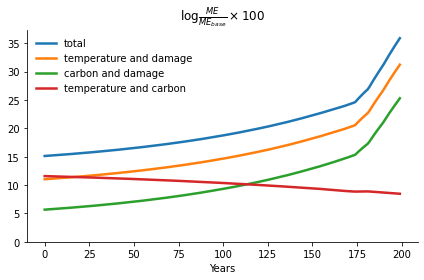

In [56]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_tempdmg/met_b)*100, label="temperature and damage")
plt.plot(np.log(met_carbdmg/met_b)*100, label="carbon and damage")
plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon")
# plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon"))
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_2type_21.png", facecolor="w", dpi=500)

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

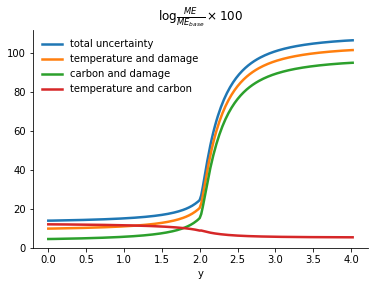

In [57]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_tempdmg/me_b)*100, label="temperature and damage")
plt.plot(y_grid, np.log(me_carbdmg/me_b)*100, label="carbon and damage")
plt.plot(y_grid, np.log(me_tempcarb/me_b)*100, label="temperature and carbon")
plt.xlabel("y")
plt.ylim(0)
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + \frac{(\eta-1)}{\delta}\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + \frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [58]:
def plot_together(et, θ_list, ht, πᶜt, πᵈt, MEt, dmg_weight):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    if np.count_nonzero(dmg_weight) > 2:
        ax1.plot(πᵈt[:,-1], label="extreme damage", color="C2")
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax2.set_xlim(0.8,3)
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_distorted - SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [59]:
def simulate_jump_ems(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y=1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@πᶜ_list + σy*h_point)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [154]:
ξa = 100000
ξw = 100000
ξp = 100000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=3, max_iter=5000)
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_bbw, et_bbw, πᵈt, πᶜt, ιt, ht = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 7.325914529324185e-05,	 ft error: 1.8219840886383547e-06
episode: 5000,	 ode error: 0.00023532655471273506,	 ft error: 4.188143125401685e-05
episode: 5000,	 ode error: 0.0011036955102757809,	 ft error: 2.729011709945439e-07
episode: 5000,	 ode error: 0.0005675509551250346,	 ft error: 5.34225959617866e-06


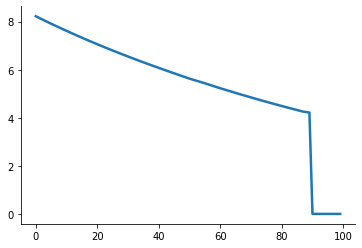

In [155]:
plt.plot(et_bb)

In [138]:
ξa = 100000
ξw = 0.3
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, max_iter=5_000)
yt_3, et_3, πᵈt, πᶜt_3, ιt, ht_3 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_3w, et_3w, πᵈt, πᶜt_3, ιt, ht_3w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 0.0005104346301074425,	 ft error: 2.3678546477630867e-05
episode: 5000,	 ode error: 0.00023846874503928583,	 ft error: 0.00010943308729268372
episode: 5000,	 ode error: 0.000987460360670117,	 ft error: 3.1945338226554064e-08
episode: 1474,	 ode error: 0.0006519126084000362,	 ft error: 9.824745461628481e-09


In [139]:
# adding equal version 1 
ξa = 100000
ξw = 0.3
ξp = 0.3
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e1, et_e1, πᵈt, πᶜt, ιt, ht_e1 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list,)
yt_e1w, et_e1w, πᵈt, πᶜt, ιt, ht_e1w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 5.814652399450948e-05,	 ft error: 1.9997413803984898e-05
episode: 760,	 ode error: 0.0002837755205893633,	 ft error: 9.97730731366886e-09
episode: 817,	 ode error: 0.0009680955968403412,	 ft error: 9.804258738199678e-09
episode: 5000,	 ode error: 0.001879725126314011,	 ft error: 6.641312343402817e-07


In [140]:
# adding equal version 2
ξa = 1000*100
ξw = 1/20*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e2, et_e2, πᵈt, πᶜt, ιt, ht_e2 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list,)
yt_e2w, et_e2w, πᵈt, πᶜt, ιt, ht_e2w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 3177,	 ode error: 8.894208216329857e-05,	 ft error: 9.778538423432792e-09
episode: 5000,	 ode error: 0.000241901747241903,	 ft error: 5.0170904475344e-05
episode: 814,	 ode error: 0.0010729152681469697,	 ft error: 9.739547834897166e-09
episode: 5000,	 ode error: 0.0007893408641111016,	 ft error: 4.773217333498003e-06


Text(0.5, 0, 'Years')

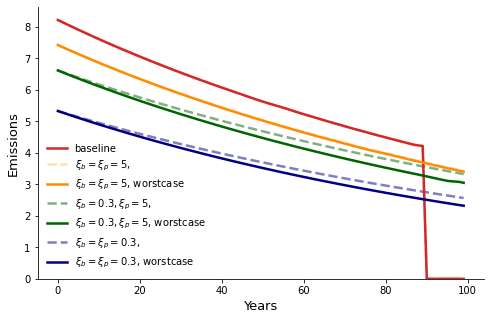

In [156]:
#
dt=1
years = np.arange(0,100,dt)
fig = plt.figure(figsize=(8,5))
plt.plot(years, et_bb, label="baseline", color="tab:red", alpha=0.3, linestyle="dashed")
plt.plot(years, et_e2, label="$ξ_b = ξ_p = 5$,", color="darkorange", alpha=0.3, linestyle="dashed")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years, et_3, label="$ξ_b =0.3,  ξ_p = 5$,", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(years, et_e1, label="$ξ_b = ξ_p = 0.3$, " , color="navy", alpha=0.5, linestyle="dashed")


plt.plot(et_bbw, label="baseline", color="tab:red")
plt.plot(et_e2w, label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(et_3w, label="$ξ_b =0.3,  ξ_p = 5$, worstcase", color="darkgreen")
plt.plot(et_e1w, label="$ξ_b = ξ_p = 0.3$, worstcase" , color="navy")


# plt.plot(et, label="with drift term + jump robust")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,1,5,2,6,3,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc=3)
# plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

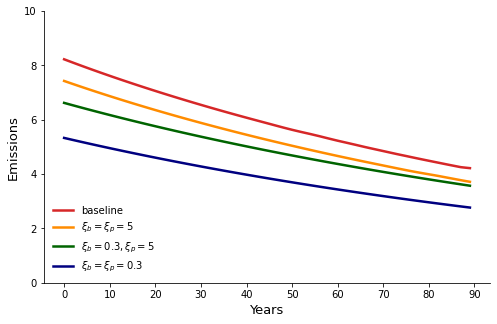

In [157]:
#
fig = plt.figure(figsize=(8,5))
plt.plot(years[et_bb>0], et_bb[et_bb>0], label="baseline", color="tab:red")
plt.plot(years[et_bb>0], et_e2[et_bb>0], label="$ξ_b = ξ_p = 5$", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years[et_bb>0], et_3[et_bb>0], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen")
plt.plot(years[et_bb>0], et_e1[et_bb>0], label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0,10)
# plt.xlim(right=95)
plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-147-07b4531d649b>:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

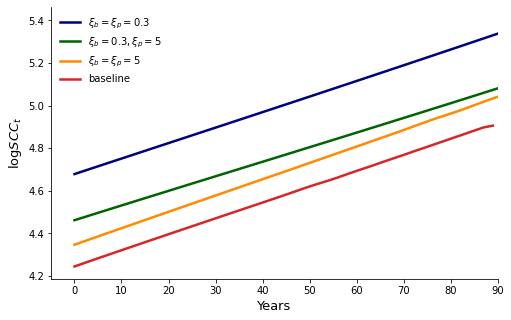

In [147]:
#
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.xticks(np.arange(0,91,10))
plt.xlim(right=90)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-130-90203d04de5d>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")
<ipython-input-130-90203d04de5d>:14: RuntimeWarning: divide by zero encountered in log
  plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

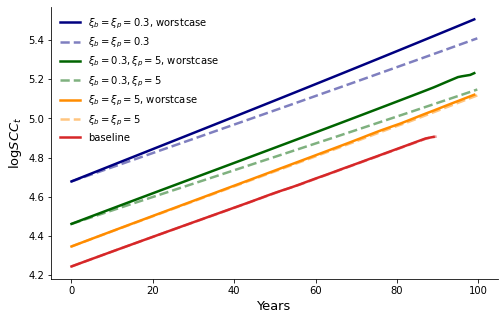

In [130]:
#
fig = plt.figure(figsize=(8,5))

plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e1w*γ1 + γ2/2*yt_e1w**2) -np.log(et_e1w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_3w*γ1 + γ2/2*yt_3w**2) -np.log(et_3w) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$, worstcase", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e2w*γ1 + γ2/2*yt_e2w**2) -np.log(et_e2w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,1,6,2,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

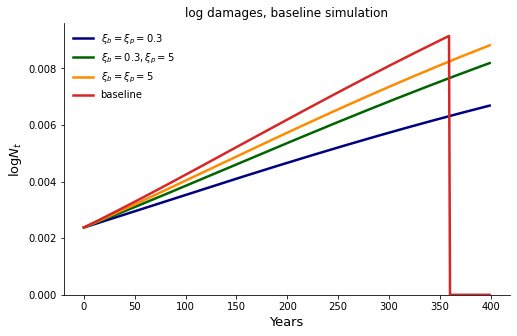

In [131]:
# log damage, baseline
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot( (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(  (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages, baseline simulation")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn_baseline.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

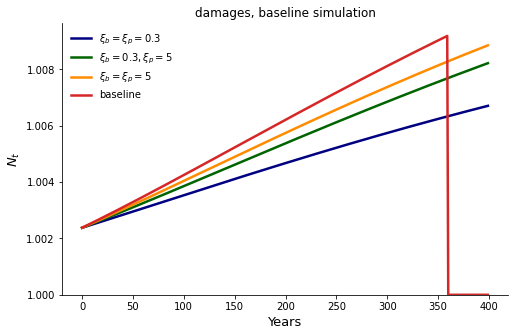

In [132]:
# damages,baseline simulation
fig = plt.figure(figsize=(8,5))
plt.plot(np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot( np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages, baseline simulation")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n_baseline.png",dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

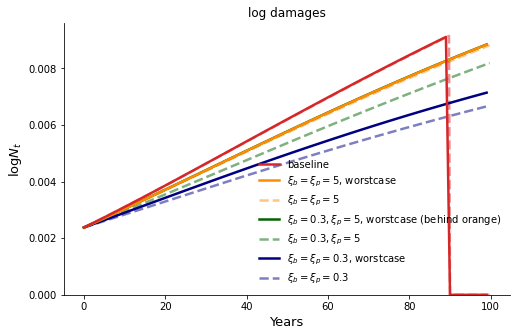

In [134]:
# log damages, worstcase
fig = plt.figure(figsize=(8,5))

plt.plot( years, (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot( years, (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot( years,  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot( years, (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( (yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot(  (yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  (yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot(  (yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

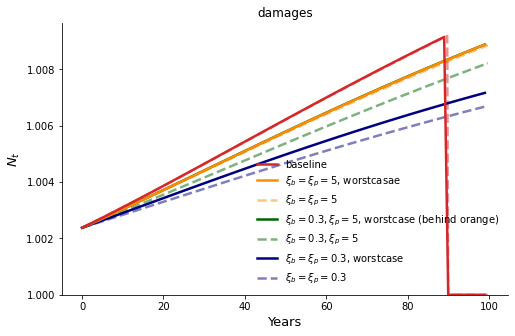

In [136]:
# damages, worstcase simulation
fig = plt.figure(figsize=(8,5))
plt.plot(years, np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(years, np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(years,  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(years,  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot(np.exp(yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.exp(yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  np.exp(yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcasae", color="darkorange")
plt.plot(  np.exp(yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-137-a1531639c577>:1: RuntimeWarning: divide by zero encountered in true_divide
  me = δ*η/et_bb


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 400

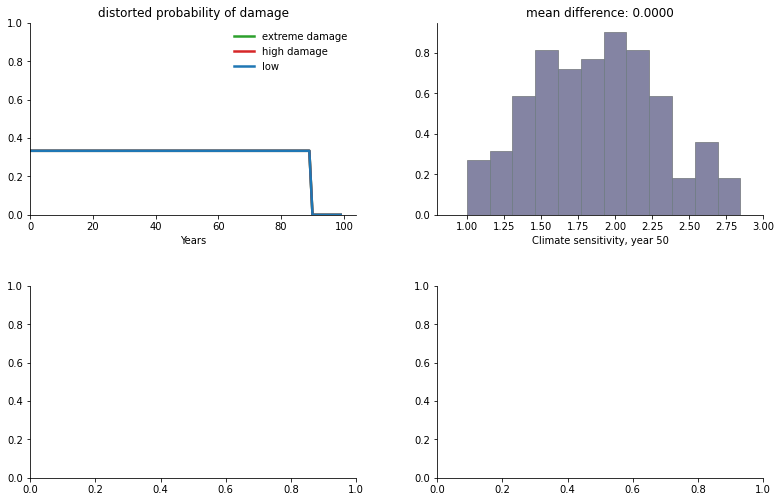

In [137]:
me = δ*η/et_bb
et_base = et_bb
fig, ((ax1, ax2), (ax3, ax4)) = plot_together(et,  θ_list, ht, πᶜt, πᵈt, me, dmg_weight)
fig.suptitle("$ξ_a = 1/100,\ ξ_w = 1/3.4,\ ξ_p =  5$")
# plt.savefig('15_600_1.pdf')
plt.show()